## Etudiant 1: GIANG Phuong-Thu, Cécile (3530406)
## Etudiant 2: LENOIR Romain (3670199)

# Régression & optimisation par descente de gradient

Ce tme a deux objectifs: 
 - acquérir les connaissances de base pour faire face au problème de la régression, c'est à dire de l'estimation d'un score réel correpondant à une situation,
 - travailler sur les techniques d'optimisation par descente de gradient

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Génération de données jouet & construction d'une solution analytique

Dans un premier temps, générons des données jouets paramétriques:
 - $N$: nombre de points à générer
 - $x \in [0, 1]$ tirage avec un simple rand() ou un linspace() -au choix-
     - Si vous optez pour un tirage aléatoire des abscisses, triez les points pour simplifier les traitements ultérieurs
 - $y=ax+b+\epsilon, \epsilon \sim \mathcal N(0,\sigma^2)$
     - Rappel : en multipliant un tirage aléatoire selon une gaussienne centrée réduite par $\sigma$ on obtient le bruit décrit ci-dessus

Afin de travailler sur les bonnes pratiques, nous distinguerons un ensemble d'apprentissage et un ensemble de test.
Les deux sont tirés selon la même distribution. L'ensemble de test comptera -arbitrairement- 1000 points.

In [2]:
def gen_data_lin(a, b, sig, N=500, Ntest=1000):
    """ Fonction qui génère N points (x, y), x tiré uniformément et y = ax + b + eps,
        avec eps suivant la loi N(0, sigma²).
        @param a: float, coefficient
        @param b: float, coefficient
        @param sig: float, écart-type de la loi normale suivie par eps
        @param N: int, nombre de points train à générer
        @param Ntest: int, nombre de points test à générer
        @return X_train, Y_train, X_test, Y_test: float array, points générés
    """
    # -- Tirage uniforme de N abscisses X_train et Ntest abscisses X_test: X ~ U(0, 1)
    X_train = np.sort(np.random.rand(N)) # tri optionnel, mais ça aide pour les plots
    X_test  = np.sort(np.random.rand(Ntest))
    
    # -- Tirage de N résidus eps_train et Ntest résidus eps_test: eps ~ N(0, sig²)
    eps_train = np.random.normal(0, sig, N)
    eps_test = np.random.normal(0, sig, Ntest)
    
    # -- Calcul des N ordonnées y_train et Ntest ordonnées y_test: Y = ax + b + eps
    y_train = a*X_train + b + eps_train
    y_test  = a*X_test + b + eps_test
    
    return X_train, y_train, X_test, y_test

**Vérification des résultats: affichage des données jouets créées**

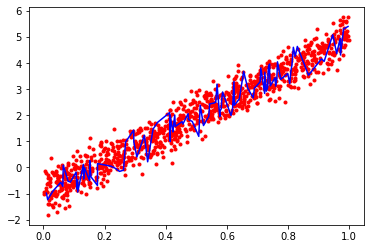

In [3]:
# génération de données jouets:
a = 6.
b = -1.
N = 100
sig = .4 # écart type

X_train, y_train, X_test, y_test = gen_data_lin(a, b, sig, N)

plt.figure()
plt.plot(X_test, y_test, 'r.')
plt.plot(X_train, y_train, 'b')

Vous devez obtenir quelque chose de la forme:
![données jouet](fig/gen_data.png)

## Validation des formules analytiques
Nous avons vu deux types de résolutions analytique: à partir des estimateurs des espérances et co-variances d'une part et des moindres carrés d'autre part. Testons les deux méthodes.

### Estimation de paramètres probabilistes
 - $\hat a = \frac{\mbox{cov}(X,Y)}{\sigma_x^2}$
 - $\hat b = E(Y)−\frac{\mbox{cov}(X,Y)}{\sigma_x^2} E(X)$
 
 Estimer les paramètres, calculer l'erreur au sens des moindres carrés sur les données d'apprentissage et de test, puis tracer la droite de régression

**Notes personnelles:**

Si $X = (x_1, ..., x_n)$ et $Y = (y_1, ..., y_n)$ sont nos données statistiques, et $\mu_x$ et $\mu_y$ leurs moyennes respectives, alors la covariance des variables $X$ et $Y$ s'écrit:

$\mbox{cov} (X, Y) = E\big[ (X - E[X]) (Y - E[Y]) \big] = \frac{1}{N} \sum_{n=1}^{N} (x_i - \mu_x)(y_i - \mu_y)$

La fonction `numpy` permettant de calculer la covariance de deux variables est `np.cov(x, y)` qui retourne la matrice 2x2:
\begin{bmatrix}
cov(x,x) & cov(x,y)\\
cov(x,y) & cov(y,y)
\end{bmatrix}

Ainsi, `np.cov(x, y)[0][1]` correspond à $cov(x,y)$, tandis que `np.cov(x, y)[0][0]` = $Var(x) = \sigma_x²$ et `np.cov(x, y)[1][1]` = $Var(y) = \sigma_y²$.

In [4]:
def modele_lin_analytique(X_train, y_train):
    """ Estime les paramètres ahat = a et bhat = b tels que y = ax + b + eps, pour les (x, y) donnés par les listes
        X_train et y_train.
        @param X_train: float array, donnée des abscisses
        @param y_train: float array, donnée des ordonnées
        @ return (ahat, bhat): (float, float), estimation des paramètres pour la régression linéaire
    """
    # -- Calcul de la covariance de X et Y (covxy) et des espérances x_mean et y_mean
    covxy = np.cov(X_train, y_train)
    x_mean = np.mean(X_train)
    y_mean = np.mean(y_train)
    
    # -- Calcul du paramètre ahat
    ahat = covxy[0][1] / covxy[0][0]
    
    # -- Calcul du paramètre bhat
    bhat = y_mean - ahat * x_mean
    
    return ahat, bhat

ahat, bhat = modele_lin_analytique(X_train, y_train)
print(ahat, bhat)

6.07445806987645 -1.0781161167166826


In [5]:
def erreur_mc(y, yhat):
    return ((y-yhat)**2).mean()

yhat_train = ahat*X_train+bhat
yhat_test  = ahat*X_test+bhat

print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat_train, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_test, y_test))

Erreur moyenne au sens des moindres carrés (train): 0.16005305990393348
Erreur moyenne au sens des moindres carrés (test): 0.172144194230722


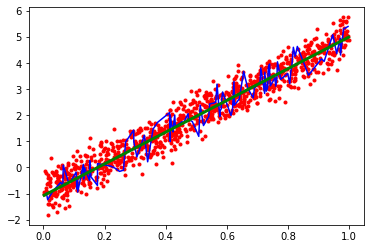

In [6]:
plt.figure()
plt.plot(X_test, y_test, 'r.')
plt.plot(X_train, y_train, 'b')
plt.plot(X_test, yhat_test, 'g', lw=3)

**Observations:**

La ligne verte correspond à la droite $y = \hat a x + \hat b$ avec $\hat a$ et $\hat b$ les paramètres que nous venons de déterminer. L'approximation semble bonne.

## Formulation au sens des moindres carrés

Nous partons directement sur une écriture matricielle. Du coup, il est nécessaire de construire la matrice enrichie $Xe$:
    $$Xe = \left[\begin{array}{cc}
                X_0 & 1\\
                \vdots & \vdots\\
                X_N & 1
                \end{array}
                \right] $$
Le code de la fonction d'enrichissement est donné ci-dessous.

Il faut ensuite poser et résoudre un système d'équations linéaires de la forme:
$$ A w = B $$
**Rappel des formules vues en cours/TD:**
$$ A=X^T X$$
$$ B=X^T Y$$
Fonction de résolution: `np.linalg.solve(A,B)`
Vous devez obtenir la même solution que précédemment. 

In [7]:
def make_mat_lin_biais(X):
    """ Fonction d'enrichissement: permet de construire la matrice enrichie Xe à partir
        du vecteur unidimensionnel X, pour le problème y = ax + b + eps.
        @param X: float array, vecteur unidimensionnel
        @return Xe: float array x array, matrice enrichie de X
    """
    N = len(X)
    return np.hstack((X.reshape(N,1),np.ones((N,1))))

In [10]:
# ------- Calcul des paramètres ahat et bhat à l'aide d'une résolution matricielle (au sens des moindres carrés)

Xe = make_mat_lin_biais(X_train)
A = np.dot(Xe.T, Xe)
B = np.dot(Xe.T, y_train)

w = np.linalg.solve(A, B)
print(w)

[ 6.07445807 -1.07811612]


In [19]:
Xe

array([[0.01002772, 1.        ],
       [0.01420318, 1.        ],
       [0.03160683, 1.        ],
       [0.05707359, 1.        ],
       [0.06362232, 1.        ],
       [0.06510576, 1.        ],
       [0.08109238, 1.        ],
       [0.08847654, 1.        ],
       [0.10701379, 1.        ],
       [0.10943989, 1.        ],
       [0.11169816, 1.        ],
       [0.11228976, 1.        ],
       [0.13086639, 1.        ],
       [0.13170958, 1.        ],
       [0.13444383, 1.        ],
       [0.15096107, 1.        ],
       [0.15146703, 1.        ],
       [0.1554991 , 1.        ],
       [0.17681252, 1.        ],
       [0.17703064, 1.        ],
       [0.22132274, 1.        ],
       [0.2334713 , 1.        ],
       [0.24911022, 1.        ],
       [0.26191149, 1.        ],
       [0.26870732, 1.        ],
       [0.29530863, 1.        ],
       [0.29571689, 1.        ],
       [0.30572892, 1.        ],
       [0.33013464, 1.        ],
       [0.34090752, 1.        ],
       [0.

In [18]:
N

100

In [16]:
X_train.reshape(N,1)

array([[0.01002772],
       [0.01420318],
       [0.03160683],
       [0.05707359],
       [0.06362232],
       [0.06510576],
       [0.08109238],
       [0.08847654],
       [0.10701379],
       [0.10943989],
       [0.11169816],
       [0.11228976],
       [0.13086639],
       [0.13170958],
       [0.13444383],
       [0.15096107],
       [0.15146703],
       [0.1554991 ],
       [0.17681252],
       [0.17703064],
       [0.22132274],
       [0.2334713 ],
       [0.24911022],
       [0.26191149],
       [0.26870732],
       [0.29530863],
       [0.29571689],
       [0.30572892],
       [0.33013464],
       [0.34090752],
       [0.35859315],
       [0.37335275],
       [0.41260254],
       [0.4145977 ],
       [0.41465116],
       [0.42035426],
       [0.42320484],
       [0.42941881],
       [0.43129186],
       [0.45351986],
       [0.45625317],
       [0.47308179],
       [0.47433325],
       [0.48669951],
       [0.50795921],
       [0.51262315],
       [0.52340301],
       [0.540

**Observations:**

Nous obtenons bien les mêmes valeurs de $\hat a$ et $\hat b$ qu'avec les estimateurs probabilistes.

Soit les données polynomiales générées avec la fonction ci-dessous
 - proposer & une solution d'enrichissement (vue en cours et TD) 
 - résoudre analytiquement le problème des moindres carrés
 - calculer l'erreur au sens des moindes carrés en apprentissage ET en test
 - tracer les données et la solution

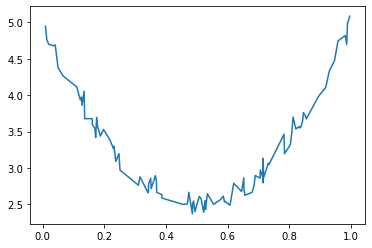

In [32]:
def gen_data_poly2(a, b, c, sig, N=500, Ntest=1000):
    '''
    Tire N points X aléatoirement entre 0 et 1 et génère y = ax^2 + bx + c + eps
    eps ~ N(0, sig^2)
    '''
    X_train = np.sort(np.random.rand(N))
    X_test  = np.sort(np.random.rand(Ntest))
    y_train = a*X_train**2+b*X_train+c+np.random.randn(N)*sig
    y_test  = a*X_test**2 +b*X_test +c+np.random.randn(Ntest)*sig
    return X_train, y_train, X_test, y_test

Xp_train, yp_train, Xp_test, yp_test = gen_data_poly2(10, -10, 5, 0.1, N=100, Ntest=100)
plt.figure()
plt.plot(Xp_train, yp_train)

**Notes personnelles:**

La fonction $y$ à estimer s'écrit désormais $y = ax² + bx + c + \epsilon$, la matrice d'enrichissement devient donc:
    $$Xe = \left[\begin{array}{cc}
                X_0² & X_0 & 1\\
                \vdots & \vdots & \vdots\\
                X_N² & X_N & 1
                \end{array}
                \right] $$

Erreur moyenne au sens des moindres carrés (train): 0.009154116088557693
Erreur moyenne au sens des moindres carrés (test): 0.009018242152998474


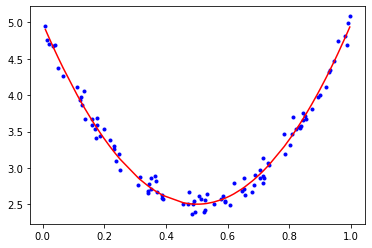

In [59]:
def make_mat_poly_biais(X):
    """ Fonction d'enrichissement: permet de construire la matrice enrichie Xe à partir
        du vecteur unidimensionnel X, pour le problème y = ax² + bx + c + eps.
        @param X: float array, vecteur unidimensionnel
        @return Xe: float array x array, matrice enrichie de X
    """
    N = len(X)
    return np.hstack((X.reshape(N,1)**2, X.reshape(N,1),np.ones((N,1))))

# -- Calcul des matrices d'enrichissement pour les données train et test
Xe   = make_mat_poly_biais(Xp_train)
Xe_t = make_mat_poly_biais(Xp_test)

# -- Estimation des paramètres a, b et c tels que y = ax² + bx + c
A = np.dot(Xe.T, Xe)
B = np.dot(Xe.T, yp_train)

w = np.linalg.solve(A, B)
a, b, c = w

yphat   = a*Xp_train**2 + b*Xp_train + c
yphat_t = a*Xp_test**2 + b*Xp_test + c

# -- Affichage des erreurs
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yphat, yp_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yphat_t, yp_test))

# -- Affichage de la fonction estimée
plt.figure()
plt.plot(Xp_train, yp_train, 'b.')
plt.plot(Xp_train, yphat, 'r')

# Fonction de coût & optimisation par descente de gradient

Comme vu en TD et en cours, nous allons maintenant résoudre le problème de la régression par minimisation d'une fonction de coût:
$$ C = \sum_{i=1}^N (y_i - f(x_i))$$

Soit un problème avec des données $(x_i,y_i)_{i=1,\ldots,N}$, une fonction de décision/prédiction paramétrée par un vecteur $w$ et une fonction de cout à optimiser $C(w)$.
Notre but est de trouver les paramètres $w^\star$ minimisant la fonction de coût:
$$ w^\star = \arg\min_w C(w)$$

l'algorithme de la descente de gradient est le suivant (rappel):

 - $w_0 \leftarrow init$ par exemple : 0
 - boucle
     - $w_{t+1} \leftarrow w_{t} - \epsilon \nabla_w C(w_t)$

Compléter le squelette d'implémentation fourni ci-dessous.


**Notes personnelles _(Calcul du gradient sous forme matricielle)_ :**

Sachant que $\frac{\partial C}{\partial w_j} = \sum_{i=1}^{N} 2 x_{ij} (f_w(x_i) - y_i)$, on déduit:

$$\nabla_w C = \left[\begin{array}{cc}
                \frac{\partial C}{\partial w_1}\\
                \vdots\\
                \frac{\partial C}{\partial w_d}
                \end{array}
                \right] 
                = 2 X^T (X w - Y)$$

In [60]:
# --- Pour travailler en matrice: (Re)-construction de la matrice contenant les X et un biais

Xe = make_mat_lin_biais(X_train) # dataset linéaire, transformation lineaire des données
A = np.dot(Xe.T, Xe)
B = np.dot(Xe.T, y_train)

wstar = np.linalg.solve(A, B)  # Pour se rappeler du w optimal

def descente_grad_mc(X, y, eps=1e-4, nIterations=100):
    """ Fonction de descente de gradient permettant de trouver le paramètre w optimal,
        ie le w qui minimise la fonction de coût. Retourne le w optimal ainsi que la liste des
        nIterations w calculés
        @param X: float array, données des abscisses
        @param y: float array, données des ordonnées
        @param eps: float, erreur/bruit/résidu
        @param nIterations: int, nombre d'itérations sur w
        @return w: float array, w optimal
        @return wall: list[float array], liste des nIterations de w
    """
    # -- ETAPE 0: Initialisation de w à 0
    w = np.zeros(X.shape[1])
    allw = [w]
    
    # ETAPE 1: Boucle sur w
    for i in range(nIterations):
        Xw = np.dot(X, w)
        w = w - eps * np.dot(2*X.T, Xw - y) # Calcul du gradient
        allw.append(w) # stockage de toutes les valeurs intermédiaires pour analyse
        
    allw = np.array(allw)
    
    return w, allw # la dernière valeur (meilleure) + tout l'historique pour le plot
    
w, allw = descente_grad_mc(Xe, y_train, eps=1e-4, nIterations=200)

On s'intéresse ensuite à comprendre la descente de gradient dans l'espace des paramètres. Le code ci-dessous permet de tracer le cout pour un ensemble de paramètres (toutes les valeurs de paramètres prises par l'algorithmes au fil du temps).


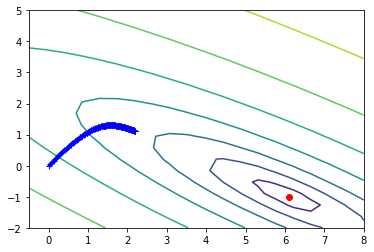

In [63]:
# tracer de l'espace des couts
def plot_parametres( allw, X, y, opti = [], ngrid = 20, extract_bornes=False):
    '''
    Fonction de tracer d'un historique de coefficients
    ATTENTION: ca ne marche qu'en 2D (évidemment)
    Chaque w doit contenir 2 valeurs
    
    Il faut fournir les données (X,y) pour calculer le cout associé 
    à un jeu de paramètres w
    ATTENTION X = forme matricielle des données
    '''
    w_min = [-0.5, -2] # bornes par défaut, uniquement pour notre cas d'usage
    w_max = [8, 5]
    if extract_bornes: # bornes générales
        w_min = np.min(allw,0) # trouver les bornes
        w_max = np.max(allw,0)
    # faire une grille régulière avec tous les couples possibles entre le min et le max
    w1range = np.linspace(w_min[0], w_max[0], ngrid)
    w2range = np.linspace(w_min[1], w_max[1], ngrid)
    w1,w2 = np.meshgrid(w1range,w2range)
    #
    # calcul de tous les couts associés à tous les couples de paramètres
    cost = np.array([[np.log(((X @ np.array([w1i,w2j])-y)**2).sum()) for w1i in w1range] for w2j in w2range])
    #
    plt.figure()
    plt.contour(w1, w2, cost)
    if len(opti) > 0:
        plt.scatter(wstar[0], wstar[1],c='r')
    plt.plot(allw[:,0],allw[:,1],'b+-' ,lw=2 )
    return

plot_parametres( allw, Xe, y_train, opti=wstar)
# plt.savefig('fig/grad_descente.png')

**Observations:**

Nous obtenons bien la figure attendue.

Vous devez obtenir un image de la forme :
![Descente de gradient](fig/grad_descente.png)

Tester différents jeux de paramètres pour mettre en évidence les phénomènes suivants:
 - Divergence du gradient
 - Convergence incomplète (trop lente ou pas assez d'itération)
 - Convergence idéale: pas de gradient suffisamment grand et nombre d'itérations bien choisi

## Mise en évidence des différents phénomènes sur la descente de gradient

**Cas n°1:** _Divergence du gradient_

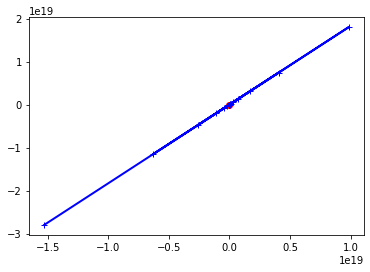

In [87]:
w, allw = descente_grad_mc(Xe, y_train, eps=1e-2, nIterations=100)
plot_parametres( allw, Xe, y_train, opti=wstar)

**Cas n°2:** _Convergence incomplète car trop lente ou pas assez d'itération_

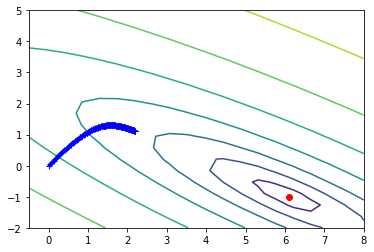

In [74]:
w, allw = descente_grad_mc(Xe, y_train, eps=1e-4, nIterations=200)
plot_parametres( allw, Xe, y_train, opti=wstar)

**Cas n°3:** _Convergence idéale, pas de gradient suffisamment grand, et nombre d'itérations bien choisi_

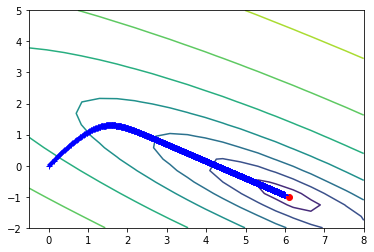

In [73]:
w, allw = descente_grad_mc(Xe, y_train, eps=1e-4, nIterations=3000)
plot_parametres( allw, Xe, y_train, opti=wstar)

# Passage sur des données réelles

Après avoir étudié trois manières de faire face au problème de la régression, nous proposons d'étudier un cas réel: la prédiction de la consommation des voitures en fonction de leurs caractéristiques.

Dans le cas présent, nous allons baser la solution sur la résolution analytique du problème des moindres carrés (`np.linalg.solve(A,B)`), qui semble la mieux adaptée au problème qui nous intéresse.

Le jeu de données est issu des datasets UCI, un répertoire parmi les plus connus en machine learning. Les données **sont déjà téléchargées et présentes dans le tme** mais vous voulez plus d'informations:
https://archive.ics.uci.edu/ml/datasets/auto+mpg

![voiture](fig/Large9.jpg)

Après avoir importé les données (fonction fournie), vous construirez une solution optimale et l'évaluerez au sens des moindres carrés en apprentissage et en test.


In [209]:
import pandas as pd
# Chargement des données
data = pd.read_csv('data/auto-mpg.data', delimiter='\s+', header=None) # comme np.loadtxt mais en plus robuste
# remplacement des données manquantes '?' => Nan pour travailler sur des nombres
data.iloc[:,[3]] = data.iloc[:,[3]].replace('?', None)
data.iloc[:,[3]] = data.iloc[:,[3]].astype(float)
# remplacement des valeurs manquantes par la moyenne
data.iloc[:,[3]] = data.iloc[:,[3]].fillna(data.iloc[:,[3]].mean())

print(data.head()) # visualiser ce qu'il y a dans les données

X = np.array(data.values[:,1:-2], dtype=np.float64)
y = np.array(data.values[:,0], dtype=np.float64)


      0  1      2      3       4     5   6  7                          8
0  18.0  8  307.0  130.0  3504.0  12.0  70  1  chevrolet chevelle malibu
1  15.0  8  350.0  165.0  3693.0  11.5  70  1          buick skylark 320
2  18.0  8  318.0  150.0  3436.0  11.0  70  1         plymouth satellite
3  16.0  8  304.0  150.0  3433.0  12.0  70  1              amc rebel sst
4  17.0  8  302.0  140.0  3449.0  10.5  70  1                ford torino


In [210]:
# ------- Séparation app/test (A COMPLETER)

def separation_train_test(X, y, pc_train=0.75):    
    # 1) Générer tous les index entre 0 et N-1
    index = np.arange(0, len(y))
    
    # 2) Mélanger la liste
    np.random.shuffle(index)
    
    # 3) Séparation des données d'entraînement et de test
    napp = int(len(y)*pc_train) # nb de points pour le train
    X_train, y_train = X[index[:napp]], y[index[:napp]]
    X_test, y_test   = X[index[napp:]], y[index[napp:]]
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = separation_train_test(X, y, pc_train=0.75)

In [211]:
# ------- Résolution analytique

def make_mat_biais(X):
    """ Fonction d'enrichissement: permet de construire la matrice enrichie Xe à partir
        du vecteur unidimensionnel X en fonction des dimensions de X.
        @param X: float array, vecteur unidimensionnel
        @return Xe: float array x array, matrice enrichie de X
    """
    dimx, dimy = X.shape
    return np.hstack((X.reshape(dimx, dimy),np.ones((dimx,1))))

Xe = make_mat_biais(X_train)
Xe_t = make_mat_biais(X_test)

A = np.dot(Xe.T,Xe)
B = np.dot(Xe.T,y_train)
w = np.linalg.solve(A,B)

yhat   = np.dot(Xe,w)
yhat_t = np.dot(Xe_t,w)

print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t, y_test))

Erreur moyenne au sens des moindres carrés (train): 11.111896378464623
Erreur moyenne au sens des moindres carrés (test): 13.494444979149495


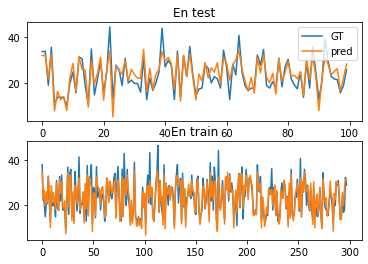

In [212]:
def plot_y(y_train, y_test, yhat, yhat_t):
    # tracé des prédictions:
    plt.figure()
    plt.subplot(211)
    plt.plot(y_test, label="GT")
    plt.plot(yhat_t, label="pred")
    plt.title('En test')
    plt.legend()
    plt.subplot(212)
    plt.plot(y_train, label="GT")
    plt.plot(yhat, label="pred")
    plt.title('En train')
    return
plot_y(y_train, y_test, yhat, yhat_t)

<BarContainer object of 7 artists>

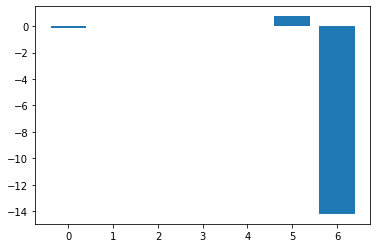

In [213]:
# interprétation des poids
plt.figure()
plt.bar(np.arange(len(w)), w)

## Normalisation

Sur le diagramme ci-dessus, on ne voit pas grand chose pour une raison évidente: on ne peut pas comparer ces poids qui comparent des variables dont les ordres de grandeur sont différents.

Nous allons donc assimiler chaque colonne $X_j$ à une variable suivant une loi normale et nous allons revenir à une Normale centrée réduite selon la formule de base:

$$X_j \sim \mathcal N(\mu_j, \sigma_j^2) $$
$$\Rightarrow Z_j = \frac{X_j - \mu_j}{\sigma_j} \sim \mathcal N(0, 1) $$

Tous les $Z_j$ sont comparables et nous seront en mesure de comprendre l'impact de chaque variables sur les résultats.

**ATTENTION:** on ne se basera que sur les données d'apprentissage pour le calcul des $\{\mu_j, \sigma_j\}$.

Une fois la normalisation effectuée, analyser l'impact des différentes variables descriptives sur la valeur à prédire.

Erreur moyenne au sens des moindres carrés (train): 11.11189637846462
Erreur moyenne au sens des moindres carrés (test): 13.335713562684191


<BarContainer object of 7 artists>

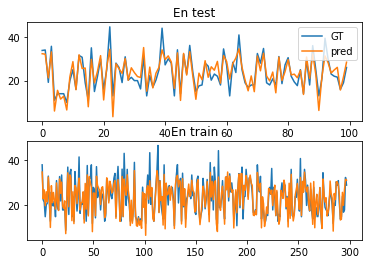

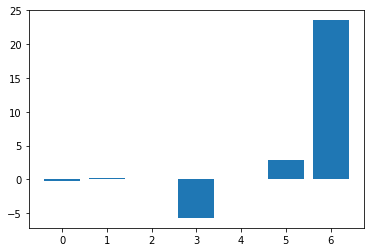

In [214]:
def normalisation(X_train, X_test):
    '''
    Fonction de normalisation des données pour rendre les colonnes comparables
    Chaque variable sera assimilée à une loi normale qu'il faut centrer + réduire.
    ATTENTION: il faut calculer les moyennes et écarts-types sur les données d'apprentissage seulement
    '''
    # ------------ ETAPE 0: Initialisation de Xn_train et Xn_test ------------
    Xn_train = np.zeros(X_train.shape)
    Xn_test = np.zeros(X_test.shape)
    
    # ------- ETAPE 1: calcul des moyennes et écarts types pour chaque colonne -------
    
    # Calcul des moyennes pour chaque colonne de X_train et de X_test
    mu_train = np.mean(X_train, axis=0)
    mu_test = np.mean(X_test, axis=0)
    
    # Calcul des écarts-types pour chaque colonne de X_train et de X_test
    sig_train = np.std(X_train, axis=0)
    sig_test = np.std(X_test, axis=0)
    
    # ----------------- ETAPE 2: Normalisation des colonnes -----------------
    for j in range(Xn_train.shape[1]):
        mu = mu_train[j]
        sig = sig_train[j]
        for i in range(Xn_train.shape[0]):
            Xn_train[i][j] = (X_train[i][j] - mu) / sig
    
    for j in range(Xn_test.shape[1]):
        mu = mu_test[j]
        sig = sig_test[j]
        for i in range(X_test.shape[0]):
            Xn_test[i][j] = (X_test[i][j] - mu) / sig
    
    # ----------------- ETAPE 3: Ajout d'un biais: fourni ci-dessous) -----------------
    Xn_train = np.hstack((Xn_train, np.ones((Xn_train.shape[0], 1))))
    Xn_test   = np.hstack((Xn_test, np.ones((X_test.shape[0], 1))))
    
    return Xn_train, Xn_test


# ----------------- AFFICHAGE DES RESULTATS -----------------

Xn_train, Xn_test = normalisation(X_train, X_test)

Xe = Xn_train
Xe_t = Xn_test
A = np.dot(Xe.T,Xe)
B = np.dot(Xe.T,y_train)
w = np.linalg.solve(A,B) 

yhat   = np.dot(Xe,w)
yhat_t = np.dot(Xe_t,w)

print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t, y_test))
plot_y(y_train, y_test, yhat, yhat_t)

plt.figure()
plt.bar(np.arange(len(w)), w)

In [215]:
X_train.shape

(298, 6)

# Questions d'ouverture

## Sélection de caractéristiques

Quels sont les résultats obtenus en éliminant toutes les variables servent moins?

## Feature engineering

En étudiant la signification des variables du problèmes, on trouve:

1. mpg: continuous 
2. cylinders: multi-valued discrete 
3. displacement: continuous 
4. horsepower: continuous 
5. weight: continuous 
6. acceleration: continuous 
7. model year: multi-valued discrete 
8. origin: multi-valued discrete 

D'après la question précédente, le poids, l'année du modèle et le biais sont des facteurs important pour le calcul de la consommation... Jusqu'ici, nous n'avons pas pris en compte l'origine qui était difficile à coder.

### Encodage de l'origine

La variable origine est accessible de la manière suivante:

```
  origine = data.values[:,-2]
```
Il faut le faire au début du traitement pour bien conserver la séparation en l'apprentissage et le test.

Au moins les deux derniers facteurs discrets pourraient être traités différemment en one-hot encoding:
$$X_j = x \in \{1, \ldots, K\} \Rightarrow [0, 0, 1, 0] \in \{0, 1\}^K$$

La valeur $x$ donne l'index de la colonne non nulle.

### Encodage de l'année

Pour l'année, il est possible de procéder de la même manière, mais il préférable de découper les années en 10 catégories puis d'encoder pour limiter le nombre de dimensions.

In [216]:
origine = data.values[:,-2]
N = len(origine)
origine = origine.reshape((N, 1))
origine = np.hstack((origine, np.zeros((N,3), dtype=int)))
for l in range(N):
    origine[l, origine[l,0]] = 1
origine = origine[:,1:]
origine



year = data.values[:,-3]
year_encoded = np.zeros((len(year),10))
bornes = np.linspace(year.min(),year.max(),11)
print(bornes)
for i in range(len(year)):
    for j in range(1,len(bornes)):
        if year[i]<=bornes[j]:
            year_encoded[i][j-1]=1
            break
print(year_encoded)




X = np.delete(X,5,1)
print(X.shape)
X = np.hstack((X, year_encoded))
print(X.shape)
X = np.hstack((X, origine))
print(X.shape)


[70.  71.2 72.4 73.6 74.8 76.  77.2 78.4 79.6 80.8 82. ]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
(398, 5)
(398, 15)
(398, 18)


In [217]:
X_train, y_train, X_test, y_test = separation_train_test(X, y, pc_train=0.75)

#EN NORMALISANT AUSSI LES ONE-HOT ENCODED
Xn_train, Xn_test = normalisation(X_train, X_test)
Ye = y_train
A = np.dot(Xn_train.T, Xn_train)
#print(A)
B = np.dot(Xn_train.T, Ye)
w = np.linalg.solve(A, B)

print("w :")
print(w)

yhat = np.dot(Xn_train,w)
yhat_t = np.dot(Xn_test,w)
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t, y_test))
plot_y(y_train, y_test, yhat, yhat_t)

plt.figure()
plt.bar(np.arange(len(w)), w)


TypeError: loop of ufunc does not support argument 0 of type float which has no callable sqrt method

# Question d'ouverture sur le gradient

## La normalisation a-t-elle un impact sur le gradient?

La normalisation des données peut au moins nous aider à régler plus facilement le pas (qui sera toujours du même ordre de grandeur... Mais cela a-t-il un impact sur la manière dont nous nous rapprochons de la solution optimale?

## Gradient stochastique

Dans la plupart des algorithmes modernes d'optimisation liés aux réseaux de neurones, le gradient est calculé de manière stochastique, sur un exemple à la fois:

- $w_0 \leftarrow init$ par exemple : 0
- boucle
     - tirage d'une donnée $i$: $(x_i,y_i)$
     - $w_{t+1} \leftarrow w_{t} - \epsilon \nabla_w C_i(w)$


Etudier le fonctionnement de cet algorithme sur les exemples jouets précédents.

## Amélioration du gradient

Le blog de S. Ruder explique particulièrement bien les améliorations possibles sur les descentes de gradient.

https://ruder.io/optimizing-gradient-descent/

Comparer une descente de gradient stochastique avec et sans moment sur les données jouets des premières questions.